In [147]:
import pymc3 as pm
import arviz as az
import numpy as np
from scipy import stats
from scipy.special import logsumexp
import pandas as pd
import matplotlib.pyplot as plt
from theano import shared 
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from patsy import dmatrix
import arviz as az

In [148]:
def r2(y_hat, y):
    e = (y_hat - y)
    var_e = np.mean((e - np.mean(e))**2)
    var_y = np.mean((y - np.mean(y))**2)
    r2 = 1 - (var_e / var_y)
    return r2

In [149]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


[]

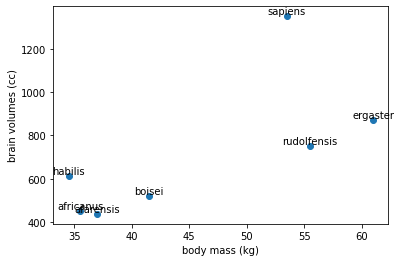

In [150]:
plt.scatter(brains.mass, brains.brain)
plt.xlabel("body mass (kg)")
plt.ylabel("brain volumes (cc)")
for index,row in brains.iterrows():
    plt.text(row.mass, row.brain, row.species, ha = "center", va = "bottom")
plt.plot()

In [151]:
# standardize
brains["mass_std"] = (brains["mass"] - brains["mass"].mean()) / brains["mass"].std()
brains["brain_std"] = brains["brain"] / np.max(brains["brain"])

In [152]:
# linear model
# vague priors we will use frequentist regression 
m7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m7_1.summary()

/home/schubertj/.local/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Tue, 29 Dec 2020   Prob (F-statistic):             0.0798
Time:                        22:04:29   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
# second degree polynomial
m7_2 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2)", data=brains).fit()

# third degree polynomial
m7_3 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3)", data=brains).fit()

# fourth degree polynomial
m7_4 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4)", data=brains).fit()

# fifth degree polynomial
m7_5 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4) + I(mass_std ** 5)", data=brains).fit()

# six degree polynomial
m7_6 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4) + I(mass_std ** 5) + I(mass_std ** 6)", data=brains).fit()

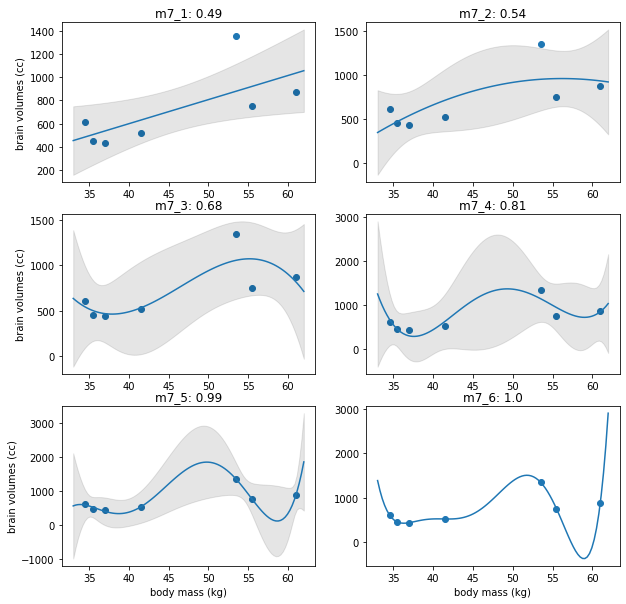

In [154]:
fig, axs = plt.subplots(3,2, figsize = (10, 10))

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

models = [m7_1, m7_2, m7_3, m7_4, m7_5, m7_6]
names = ["m7_1", "m7_2", "m7_3", "m7_4", "m7_5", "m7_6"]

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha = 0.11) * brains.brain.max()
    
    ax.plot(mass_plot, pred["mean"])
    ax.scatter(brains.mass, brains.brain)
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha = 0.1, color = "black")
    ax.set_title("{}: {}".format(name, np.round(model.rsquared, 2)))
    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")
    if ax.is_first_col():
        ax.set_ylabel("brain volumes (cc)")

In [155]:
n_samples = 3000

# covariance of coefficients comes from natiaral variantion we would expect in X
intercept, slope = (
    stats.multivariate_normal(m7_1.params, m7_1.cov_params()).rvs(n_samples).T
)

# we can also bootstrap and calculate params from bootstrapped samples
intercept_ = np.zeros(n_samples)
slope_ = np.zeros(n_samples)
for n in range(n_samples):
    n_rows = range(brains.shape[0] - 1)
    # sample randomly from the data
    i = np.random.choice(n_rows, size=brains.shape[0], replace=True)
    dat_aux = brains.iloc[i,:]
    #fit a model
    m_aux = smf.ols("brain_std ~ mass_std", data=dat_aux).fit()
    intercept_[n], slope_[n] = m_aux.params

In [156]:
pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)
pred_ = intercept_ + slope_ * brains.mass_std.values.reshape(-1, 1)

n, ns = pred.shape

In [157]:
pred

array([[0.37259952, 0.29674465, 0.34382871, ..., 0.39754297, 0.41306434,
        0.41900101],
       [0.34343398, 0.2650781 , 0.32119473, ..., 0.37333231, 0.40246212,
        0.39831775],
       [0.32399029, 0.24396706, 0.30610541, ..., 0.35719186, 0.39539397,
        0.38452891],
       ...,
       [0.73230782, 0.68729881, 0.62298111, ..., 0.69614118, 0.54382511,
        0.67409453],
       [0.83924812, 0.80340951, 0.70597236, ..., 0.78491363, 0.58269993,
        0.74993314],
       [0.69342043, 0.64507674, 0.59280247, ..., 0.6638603 , 0.52968881,
        0.64651685]])

In [158]:
sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.62209883,  0.65959023,  0.55391373,  0.62944711,  0.47320682,
        0.44046318, -0.84349947])

In [159]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix (1 and x values)
    pred = dmat.dot(pars) # matrix multiply each observation to get pred for each sample 

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (
        np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7
    ) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s]) # same as likelihood
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [160]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.53173649,  2.34500658,  2.86957109,  3.5381545 , 11.00824168])

### Training and Test sample

We want to simulate the following model

$y_i \sim Normal(\mu_i, 1)$

$\mu_i = 0.15x_{1,i} -0.4x_{2,i}$ 

In [161]:
def m_sim(s):
    x1 = stats.norm.rvs(size=s)
    x2 = stats.norm.rvs(size=s)
    mu = 0.15*x1 -0.4*x2
    y = stats.norm.rvs(mu, 1, size=s)
    return {"y": y, "x1": x1, "x2": x2}

In [162]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc3

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            testval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(
        stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1)
    )

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(
        stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1)
    )

    return np.mean(dev_train), np.mean(dev_test)

n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

In [163]:
### Calculate WAIC

In [164]:
cars = pd.read_csv("https://raw.githubusercontent.com/schubertjan/resources/master/Rethinking_2/Data/cars.csv", index_col=0)
cars.head()

,speed,dist
1,4,2
2,4,10
3,7,4
4,7,22
5,8,16


In [165]:
m = pm.Model()

with m:
    a = pm.Normal("a", 0, 100)
    b = pm.Normal("b", 0, 10)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b*cars["speed"].values)
    dist = pm.Normal("dist", mu, sigma, observed = cars.dist.values)
    m_trace = pm.sample(draws=1000)
    m_post = pm.sample_posterior_predictive(m_trace, var_names=["dist", "mu", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [166]:
n = cars.shape[0]
n_samples = 4000
logprob = np.zeros((n, n_samples))
#extract mu from samples
mu = m_post["mu"].T
sigma = m_post["sigma"].T

#calculate log likelihood
for s in range(n_samples):
    mu_s = mu[:, s]
    logprob[:, s] = stats.norm.logpdf(cars.dist, loc = mu_s, scale = sigma[s])

lppd = np.zeros(n)
#calculate lppd
for i in range(n):
    lppd[i] = logsumexp(logprob[i, :]) - np.log(n_samples)

#calculate WAIC by adding regularizing penalty
pWAIC = np.zeros(n)
for i in range(n):
    pWAIC[i] = np.var(logprob[i, :])

# calculate WAIC
print(-2 * (np.sum(lppd) - np.sum(pWAIC)))

# compute WAIC standard error
waic_vec = -2 * (lppd - pWAIC)
print((n * np.var(waic_vec)) ** 0.5)

421.64171280584196
16.301264090461228


Or use arviz to estimate PSIS nad WAIC

In [167]:
az.loo(m_trace, scale = "deviance")

Computed from 4000 by 50 log-likelihood matrix

              Estimate       SE
deviance_waic   421.64    16.30
p_waic            4.18        -

There has been a warning during the calculation. Please check the results.

In [168]:
az.waic(m_trace, scale = "deviance")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8862944886715791, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [169]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame(
    {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}
)

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample(return_inferencedata=True)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_7,0,351.83,3.16197,0,0.999675,12.9051,0,False,deviance
m6_8,1,388.836,2.53006,37.0056,2.90215e-05,10.9764,8.14819,False,deviance
m6_6,2,399.51,1.50028,47.6796,0.000296075,14.6963,12.488,False,deviance


<AxesSubplot:xlabel='Deviance'>

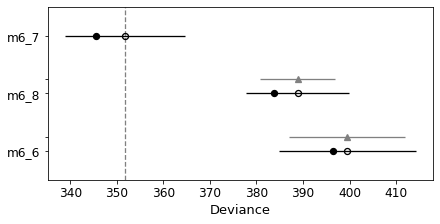

In [170]:
m6_comp = az.compare({"m6_6": m_6_6_trace, "m6_7": m_6_7_trace, "m6_8": m_6_8_trace}, scale="deviance", ic = "waic")
m6_comp

az.plot_compare(m6_comp)

A wrong model with confounding variable is still prefered because it is the model that has the best out-of-sample prediction

In [171]:
### Outliers

In [172]:
d = pd.read_csv("https://raw.githubusercontent.com/schubertjan/resources/master/Rethinking_2/Data/WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [173]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_1_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_2_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_3_trace = pm.sample(return_inferencedata=True)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,127.25,3.92385,0,0.583235,13.2468,0,False,deviance
m_5_3,1,128.35,4.61299,1.10019,0.330343,9.97413,0.918026,False,deviance
m_5_2,2,140.338,2.96516,13.0876,0.0864219,12.8061,9.5747,False,deviance


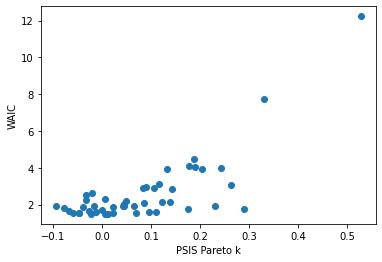

In [174]:
az.compare(
    {"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace}, scale="deviance",
)

In [175]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

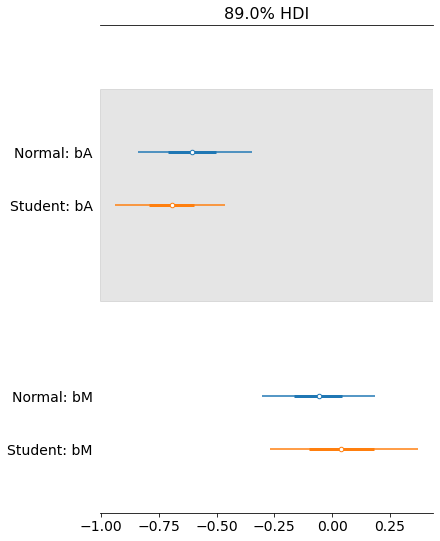

In [176]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", 2, mu, sigma, observed=d["D"])

    m_5_3t_trace = pm.sample(return_inferencedata=True)

In [177]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], 
                model_names = ["Normal", "Student"],
                var_names = ["bA", "bM"],
                combined = True, 
                credible_interval = 0.89)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Normal,0,128.35,4.61299,0,0.781414,13.3941,0,False,deviance
Student,1,133.244,5.42341,4.89359,0.218586,11.1482,5.61766,False,deviance


In [ ]:
az.compare({"Normal": m_5_3_trace, "Student": m_5_3t_trace}, scale = "deviance")